In [1]:
import os
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (8.0, 6.0)

# Loading the model

Start loading the Facenet [pre-trained model](https://github.com/davidsandberg/facenet) chosen.

We are using **TensorFlow** version 1.10.1 on this notebook, and loading the model trained with the VGGFace2 dataset using the network architecture **Inception ResNet v1**. 

| Models                      | LFW accuracy    | Training Dataset                | Architecture                |
| ------------------------------- | :------------------------: | --------------------------------------: | --------------------------------: |
| 20180408-102900   | 0.9905                 | CASIA-WebFace               | Inception ResNet v1 |
| 20180402-114759   | 0.9965                 | VGGFace2                         | Inception ResNet v1 |


In [2]:
def get_filenames(filepath):
    list_files = os.listdir(filepath)
    for filename in list_files:
        if filename.endswith('meta'):
            model_file = filename
        elif filename.endswith('index'):
            ckpt_file = filename.strip('.index')
            
    return model_file, ckpt_file

def load_model(filepath, input_map=None):
    if os.path.isfile(filepath):
        print('Loading files:')
        print(f'Model filename: {filepath}')
        
        with tf.compat.v1.gfile.FastGFile(filepath, 'rb') as f:
            graph_def = tf.compat.v1.GraphDef()
            graph_def.ParseFromString(f.read())
            tf.import_graph_def(graph_def, input_map=input_map, name='')
            
    else:
        model_file, ckpt_file = get_filenames(filepath)
        curr_sess = tf.compat.v1.get_default_session()
        
        print('Loading files:')
        print(f'Model: {model_file}')
        print(f'Checkpoint: {ckpt_file}')
        
        saver = tf.compat.v1.train.import_meta_graph(os.path.join(filepath, model_file),
                                                    input_map=input_map)
        saver.restore(curr_sess, os.path.join(filepath, ckpt_file))
        
    print('Succeeded!')

In [3]:
# For GPU support
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))

sess = tf.compat.v1.Session()

In [4]:
load_model('models/facenet/20180402-114759/20180402-114759.pb')

Loading files:
Model filename: models/facenet/20180402-114759/20180402-114759.pb
Instructions for updating:
Use tf.gfile.GFile.
Succeeded!


# Loading Test Images

In [5]:
def get_random_image(dataset_path, plot=False):
    list_people = os.listdir(dataset_path)
    get_random = lambda x: x[np.random.randint(len(x))]
    
    chosen_person = get_random(list_people)
    
    list_images = os.listdir(os.path.join(dataset_path, chosen_person))
    random_image = get_random(list_images)
    img_path = os.path.join(dataset_path, chosen_person, random_image)
    
    img = plt.imread(img_path)
    
    if plot:
        plt.imshow(img)
        plt.title(chosen_person)
        plt.axis('off')
    
    return img_path, img

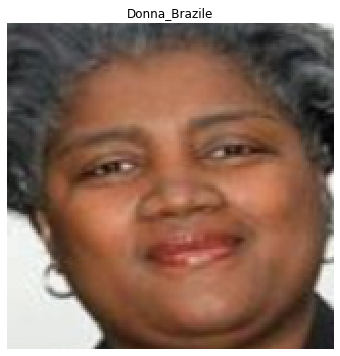

In [6]:
img_path, original_image = get_random_image('data/lfw/lfw_mtcnnpy_160/', plot=True)

# Embeddings

The main goal on this notebook is to perform forward propagation on all images on our [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) dataset, building a dataset with the embeddings that were outputed from the pre-trained ResNet v1. 

Those embeddings will be used to train a smaller model, trying to perform as close as possible as the ResNet accuracy. The smaller model will try to learn how an image is processed from the *raw pixels* to the *embeddings vector*, and therefore will use the embeddings output from the ResNet model.  

## Forward Propagation

First, we'll check how it's the procedure to perform forward propagation on only one image. To read the image, we'll use the matplotlib's `imread` function, and then we'll use the pre-trained model to get the embedding vector from the image. 

All the images on this notebook were pre processed using [Multi-task CNN](https://kpzhang93.github.io/MTCNN_face_detection_alignment/index.html) for detection and alignment of the faces using this [Python implementation](https://github.com/davidsandberg/facenet/tree/master/src/align).To avoid computational cost, there are no intention on doing such pre process on the real time images on Raspberry.

In [7]:
images_placeholder = tf.compat.v1.get_default_graph().get_tensor_by_name('input:0')
embeddings = tf.compat.v1.get_default_graph().get_tensor_by_name('embeddings:0')
phase_train_placeholder = tf.compat.v1.get_default_graph().get_tensor_by_name('phase_train:0')

In [8]:
nrof_images = 1
images = original_image.reshape((nrof_images, *original_image.shape))

In [ ]:
feed_dict = {images_placeholder: images, phase_train_placeholder: False}
embeddings_array = sess.run(embeddings, feed_dict=feed_dict)

In [46]:
embeddings_array

512